# Imports

Benefits of This Step:

Grouped imports by function (viz, system, NLP)

Descriptive comments improve readability

Adds a clear structure before actual data handling or RAG logic starts

In [ ]:

import sys
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
warnings.filterwarnings('ignore')

%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-openai

from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import CSVLoader, TextLoader
from langchain_core.vectorstores import InMemoryVectorStore

In [ ]:
pip install langchain sentence-transformers

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
csv_file_path = '/content/drive/My Drive/medquad.csv'

df = pd.read_csv(csv_file_path)
df.head(100)

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
...,...,...,...,...
95,What is (are) Anxiety Disorders ?,Anxiety disorders are a collection of disorder...,NIHSeniorHealth,Anxiety Disorders
96,What is (are) Anxiety Disorders ?,"All of us worry about things like health, mone...",NIHSeniorHealth,Anxiety Disorders
97,What is (are) Anxiety Disorders ?,"In social phobia, a person fears being judged ...",NIHSeniorHealth,Anxiety Disorders
98,What is (are) Anxiety Disorders ?,"In panic disorder, a person has sudden, unexpl...",NIHSeniorHealth,Anxiety Disorders


# Validation: Missing Value Analysis

In [52]:

missing_counts = df.isnull().sum()
print("🧼 Missing values summary:")
print(missing_counts[missing_counts > 0])


initial_count = len(df)
df.dropna(subset=["answer", "focus_area"], inplace=True)
final_count = len(df)


print(f" Cleaned dataset now has {final_count} rows.")

🧼 Missing values summary:
Series([], dtype: int64)
 Cleaned dataset now has 16393 rows.


# Preview Focus Area Distributions



# Analyze Distributions



 Unique focus areas: 5125


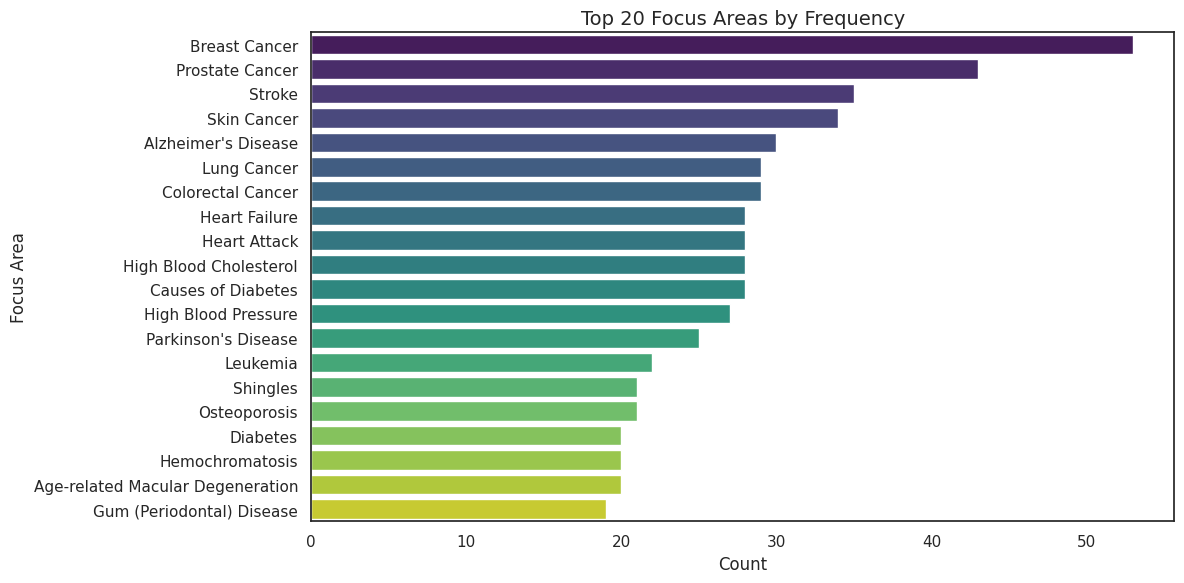

In [5]:

unique_focus_areas = df['focus_area'].nunique()
print(f" Unique focus areas: {unique_focus_areas}")


top_focus_areas = df['focus_area'].value_counts().head(20)


plt.figure(figsize=(12, 6))
sns.barplot(x=top_focus_areas.values, y=top_focus_areas.index, palette='viridis')
plt.title("Top 20 Focus Areas by Frequency", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Focus Area")
plt.tight_layout()
plt.show()

# Build Embeddings from All Focus Areas

In [6]:

focus_areas = df['focus_area'].unique().tolist()
focus_areas.sort()


df_focus = pd.DataFrame({'focus_area': focus_areas})
df_focus.to_csv('./focus_areas.csv', index=False)


docs = CSVLoader('./focus_areas.csv').load()
print(f"📄 Loaded {len(docs)} focus area documents.")

📄 Loaded 5125 focus area documents.


# Build Vector Store + Search by “Cancer”

In [ ]:
# Initialize embeddings
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# Build vector store
vector_store = InMemoryVectorStore.from_documents(docs, embeddings)

# Search for topics similar to "cancer"
related_docs = vector_store.similarity_search("cancer", k=150)


cancer_topics = [doc.page_content.split("focus_area: ")[1] for doc in related_docs]



# Filter Original Dataset by These Topics

In [11]:
# Filter main dataframe
cancer_df = df[df['focus_area'].isin(cancer_topics)]
print(f"📉 Filtered dataset size: {cancer_df.shape}")

📉 Filtered dataset size: (760, 4)


# Preview Sample Cancer Q&A



In [12]:
# Show 5 random examples
cancer_df.sample(5, random_state=42)[['focus_area', 'question', 'answer']]

,focus_area,question,answer
1137,Gastrointestinal Carcinoid Tumors,What are the treatments for Gastrointestinal C...,Key Points\n - There are di...
1031,Transitional Cell Cancer of the Renal Pelvis a...,What is the outlook for Transitional Cell Canc...,Certain factors affect prognosis (chance of re...
470,Leukemia,What are the treatments for Leukemia ?,"Researchers are studying various drugs, immuno..."
1381,Male Breast Cancer,How to diagnose Male Breast Cancer ?,Tests that examine the breasts are used to det...
482,Lung Cancer,Who is at risk for Lung Cancer? ?,"If you smoke cigarettes, you are at much highe..."


# Focus Area Distribution

This shows which cancers dominate the dataset (e.g., breast, prostate, skin).

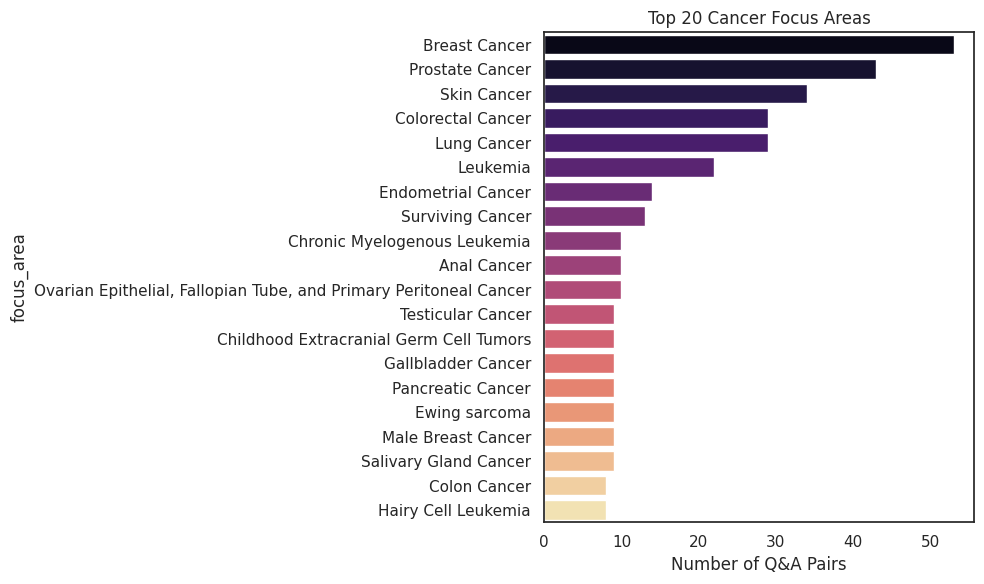

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cancer_df, y='focus_area', order=cancer_df['focus_area'].value_counts().head(20).index, palette='magma')
plt.title("Top 20 Cancer Focus Areas")
plt.xlabel("Number of Q&A Pairs")
plt.tight_layout()
plt.show()

# Question Length Analysis

📝 Question length (words):
count    760.000000
mean       8.317105
std        2.373708
min        4.000000
25%        6.000000
50%        8.000000
75%        9.000000
max       19.000000
Name: question_length, dtype: float64


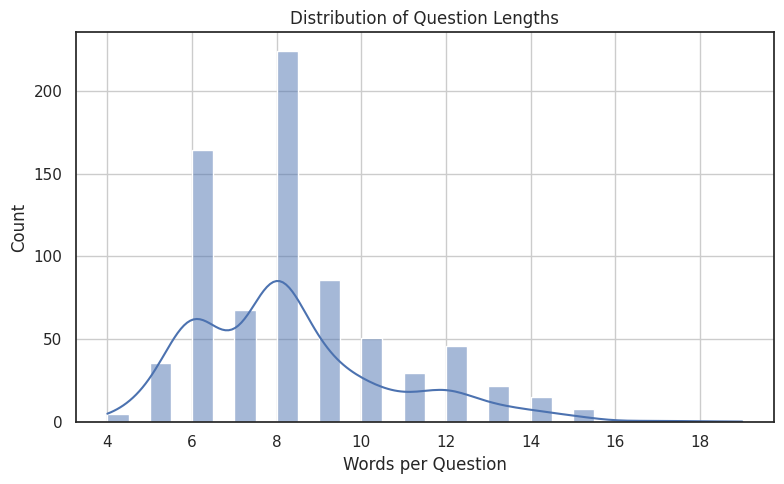

In [14]:
# Add column for question length
cancer_df['question_length'] = cancer_df['question'].apply(lambda x: len(str(x).split()))

# Summary stats
print("📝 Question length (words):")
print(cancer_df['question_length'].describe())

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(cancer_df['question_length'], bins=30, kde=True)
plt.title("Distribution of Question Lengths")
plt.xlabel("Words per Question")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
cancer_df.head(100)

,question,answer,source,focus_area,question_length
168,What is (are) Prostate Cancer ?,How Tumors Form The body is made up of many ty...,NIHSeniorHealth,Prostate Cancer,6
169,Who is at risk for Prostate Cancer? ?,Scientists don't know exactly what causes pros...,NIHSeniorHealth,Prostate Cancer,8
170,What are the symptoms of Prostate Cancer ?,"Symptoms Most cancers in their early, most tre...",NIHSeniorHealth,Prostate Cancer,8
171,What are the treatments for Prostate Cancer ?,"If tests show that you have cancer, you should...",NIHSeniorHealth,Prostate Cancer,8
172,What are the treatments for Prostate Cancer ?,Choosing Treatment There are a number of ways ...,NIHSeniorHealth,Prostate Cancer,8
...,...,...,...,...,...
468,What is (are) Leukemia ?,Radiation therapy is a cancer treatment that u...,NIHSeniorHealth,Leukemia,5
469,what research (or clinical trials) is being do...,Clinical trials are research studies in which ...,NIHSeniorHealth,Leukemia,11
470,What are the treatments for Leukemia ?,"Researchers are studying various drugs, immuno...",NIHSeniorHealth,Leukemia,7
471,What is (are) Lung Cancer ?,How Tumors Form The body is made up of many ty...,NIHSeniorHealth,Lung Cancer,6


# Save Filtered Dataset

In [50]:

cancer_df.to_csv('./cancer_qna.csv', index=False)


# Cancer Q&A Embedding with Batching

In [19]:

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


qa_docs = [
    Document(
        page_content=f"Question: {row['question']}\nAnswer: {row['answer']}",
        metadata={"focus_area": row["focus_area"]}
    )
    for _, row in cancer_df.iterrows()
]


def embed_in_batches(documents, batch_size=100):
    """
    Embed documents using OpenAI and store them in a memory vector store,
    processing in batches to avoid exceeding the token limit.

    Args:
        documents (List[Document]): List of LangChain Document objects.
        batch_size (int): Number of docs to embed per API call.

    Returns:
        InMemoryVectorStore: Vector store containing embedded documents.
    """
    vector_store = InMemoryVectorStore(embedding=embeddings)
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]
        vector_store.add_documents(batch)
    return vector_store


vector_store = embed_in_batches(qa_docs)


# Test Retrieval

In [23]:
results = vector_store.similarity_search("What causes Lung Cancer ?", k=5)
for doc in results:
    print(doc.page_content)
    print("---")

Question: What is (are) Lung Cancer ?
Answer: Lung cancer is one of the most common cancers in the world. It is a leading cause of cancer death in men and women in the United States. Cigarette smoking causes most lung cancers. The more cigarettes you smoke per day and the earlier you started smoking, the greater your risk of lung cancer. High levels of pollution, radiation and asbestos exposure may also increase risk.     Common symptoms of lung cancer include       - A cough that doesn't go away and gets worse over time    - Constant chest pain    - Coughing up blood    - Shortness of breath, wheezing, or hoarseness    - Repeated problems with pneumonia or bronchitis    - Swelling of the neck and face    - Loss of appetite or weight loss    - Fatigue       Doctors diagnose lung cancer using a physical exam, imaging, and lab tests. Treatment depends on the type, stage, and how advanced it is. Treatments include surgery, chemotherapy, radiation therapy, and targeted therapy. Targeted th

# RAG Prompting with flan-t5-base



# Setup Prompt & State

In [25]:
from pydantic import BaseModel
from typing import List, Dict, Optional
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")
class State(BaseModel):
    question: str
    context: Optional[List[Dict]]
    answer: str

# Retrieval and Generation Functions

In [46]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
pipe = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7
)
llm = HuggingFacePipeline(pipeline=pipe)

def retrieve(db, state: State):
    retrieved_docs = db.similarity_search(state.question, k=2)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state.context)
    prompt_text = (
        "You are a helpful medical assistant. Based on the context below, "
        "give a comprehensive and detailed answer to the question.\n\n"
        f"Context:\n{docs_content}\n\n"
        f"Question: {state.question}\n\n"
        "Answer with as much detail as possible:"
    )
    response = llm(prompt_text)
    return {"answer": response}

Device set to use cpu


# Full Pipeline: Retrieve and Generate

In [47]:

def retrieve_and_generate(user_prompt):
    state = State(question=user_prompt, context=None, answer="")
    context = retrieve(vector_store, state)
    state.context = context['context']
    gen = generate(state)
    return gen["answer"]

# Ask a Question

In [48]:
question = "What are the early symptoms of breast cancer?"
response = retrieve_and_generate(question)

print("User Question:\n", question)
print("\nRAG Answer:\n", response)

/tmp/ipython-input-46-2442298109.py:26: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt_text)
Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors


User Question:
 What are the early symptoms of breast cancer?

RAG Answer:
 A lump or thickening in or near the breast or in the underarm area. - A change in the size or shape of the breast. - A dimple or puckering in the skin of the breast. - A nipple turned inward into the breast. - Fluid, other than breast milk, from the nipple, especially if it's bloody. - Scaly, red, or swollen skin on the breast, nipple, or areola (the dark area of skin around the nipple). - Dimples in the breast that look like the skin of an orange, called peau dorange.


In [49]:

questions = [
    "What are the early symptoms of colon cancer?",
    "How is leukemia diagnosed?",
    "What are the common treatments for breast cancer?",
    "Can chemotherapy be used for prostate cancer?",
    "What does stage 3 lung cancer mean?",
    "Is pancreatic cancer curable?",
    "What increases the risk of cervical cancer?",
    "Can HPV vaccination help prevent cancer?",
    "What is remission in cancer?",
    "How do I manage side effects from radiation therapy?"
]

from IPython.display import display, Markdown

def batch_test_rag(questions_list):
    """
    Run RAG retrieval and generation for a list of questions.
    Nicely display each question and the generated answer.

    Args:
        questions_list (list[str]): A list of questions to query.
    """
    display(Markdown("# 🔎 **Batch RAG Test Results**"))
    for idx, question in enumerate(questions_list, start=1):

        answer = retrieve_and_generate(question)


        display(Markdown(f"## {idx}. ❓ **Question:**"))
        display(Markdown(f"> {question}"))
        display(Markdown(f"✅ **Answer:**\n\n{answer.strip()}"))
        display(Markdown("---"))

batch_test_rag(questions)

# 🔎 **Batch RAG Test Results**

## 1. ❓ **Question:**

> What are the early symptoms of colon cancer?

✅ **Answer:**

Diarrhea, constipation, or feeling that the bowel does not empty all the way.

---

## 2. ❓ **Question:**

> How is leukemia diagnosed?

✅ **Answer:**

Your doctor may request lab analyses for leukemia that include blood tests that check the levels and types of blood cells and look for changes in the shape of blood cells. The doctor may also look for signs of leukemia in the bone marrow or the fluid around the brain or the spinal cord

---

## 3. ❓ **Question:**

> What are the common treatments for breast cancer?

✅ **Answer:**

You can seek conventional treatment from a specialized cancer doctor, called an oncologist. The oncologist will usually assemble a team of specialists to guide your therapy. Besides the oncologist, the team may include a surgeon, a radiation oncologist who is a specialist in radiation therapy, and others. Before starting treatment, you may want another doctor to review the diagnosis and treatment plan. Some insurance companies require a second opinion. Others may pay for a second opinion if you request it.

---

## 4. ❓ **Question:**

> Can chemotherapy be used for prostate cancer?

✅ **Answer:**

Scientists are also testing the effectiveness of chemotherapy and biological therapy for men whose cancer does not respond or stops responding to hormonal therapy. This treatment is often used for prostate cancer that has spread to other parts of the body. In 2010, the FDA approved a therapeutic cancer vaccine, Provenge, for use in some men with metastatic prostate cancer. This approval was based on the results of a clinical trial that demonstrated a more than 4-month improvement in overall survival compared with a placebo vaccine.

---

## 5. ❓ **Question:**

> What does stage 3 lung cancer mean?

✅ **Answer:**

Stage IIIA is divided into three sections depending on the size of the tumor, where the tumor is found, and which lymph nodes have cancer (if any).

---

## 6. ❓ **Question:**

> Is pancreatic cancer curable?

✅ **Answer:**

Pancreatic cancer can be controlled only if it is found before it has spread, when it can be completely removed by surgery. If the cancer has spread, palliative treatment can improve the patient's quality of life by controlling the symptoms and complications of this disease.

---

## 7. ❓ **Question:**

> What increases the risk of cervical cancer?

✅ **Answer:**

Being infected with human papillomavirus (HPV).

---

## 8. ❓ **Question:**

> Can HPV vaccination help prevent cancer?

✅ **Answer:**

The Hepatitis A vaccine and the hepatitis B vaccine prevent infection with hepatitis A and hepatitis B.

---

## 9. ❓ **Question:**

> What is remission in cancer?

✅ **Answer:**

Whether the cancer has just been diagnosed or has recurred (come back).

---

## 10. ❓ **Question:**

> How do I manage side effects from radiation therapy?

✅ **Answer:**

Summary : Talk to your doctor to make sure that all aspects of your cancer care work together. Some methods, such as acupuncture, might help with nausea, pain and other side effects of cancer treatment. Talk to your doctor to make sure that all aspects of your cancer care work together.

---